This notebook explores how to plot the Matlab format files that CReSIS hosts on their own server:

https://data.cresis.ku.edu/data/rds/

In [1]:
import numpy as np
import os
import pyproj

In [2]:
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt

In [3]:
# Ugggh. Turns out that scipy.io can't handle Matlab v7.3 files (which aren't all that new -- supported in R2006b)
import h5py  # `pip3 install h5py`

In [4]:
import scipy  # I had to do `pip3 install scipy`
import scipy.io

In [5]:
data_dir = "/Users/lindzey/RadarData/ANTARCTIC/"
os.listdir(data_dir)

['AWI',
 'BAS',
 'BEDMAP',
 'CRESIS',
 'KOPRI',
 'LDEO',
 'SOAR',
 'STANFORD',
 'UTIG',
 'RNRF',
 'PRIC']

In [6]:
segment_dir = os.path.join(data_dir, "CRESIS/2013_Antarctica_Basler/CSARP_mvdr/20131219_01")
os.listdir(segment_dir)

['Data_20131219_01_001.mat',
 'Data_20131219_01_002.mat',
 'Data_20131219_01_003.mat',
 'Data_20131219_01_004.mat',
 'Data_20131219_01_005.mat',
 'Data_20131219_01_006.mat',
 'Data_20131219_01_007.mat',
 'Data_20131219_01_008.mat',
 'Data_20131219_01_009.mat',
 'Data_20131219_01_010.mat',
 'Data_20131219_01_011.mat']

In [7]:
datapath = "{}/Data_20131219_01_005.mat".format(segment_dir)

In [8]:
datapath = "/Users/lindzey/RadarData/ANTARCTIC/CRESIS/2009_Antarctica_DC8/CSARP_mvdr/20091102_02/Data_20091102_02_024.mat"

In [9]:
mm = scipy.io.loadmat(datapath)

In [10]:
mm['Data'].shape, mm['Elevation'].shape

((625, 5679), (1, 5679))

In [11]:
mm.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Bottom', 'Data', 'Depth', 'Elevation', 'GPS_time', 'Latitude', 'Longitude', 'Surface', 'Time'])

In [12]:
mm['Longitude'].flatten()

array([-114.47163013, -114.47185059, -114.47207188, ..., -114.52708685,
       -114.52667387, -114.52626156])

In [13]:
def plot_cresis_matlab_radargram(filepath, xlim=None, highlighted_traces=None):
    """
    Like the netCDF file, there are a lot of non-obvious variables in this one.
    
    Unlike the netCDF file, I needed to take the log of the data for it to show up in a plot.
    
    We can't use scipy.io since it doesn't work for verion 7.3 of the matlab file format.
    Instead, use a HDF reader.
    """
    
    with h5py.File(filepath, 'r') as data:
        radargram = data['Data']    
        print(type(radargram))
        lat = data['Latitude']
        lon = data['Longitude']

        # First dimension is fast time, 2nd dimension is slow time. We want the other way around for plotting.
        radargram = np.log(np.array(radargram).transpose())
        print(radargram.shape, lat.shape)
        ps71 = pyproj.Proj("epsg:3031")
        xx, yy = ps71.transform(lon, lat)
    
        print("Radargram shape: {}, lat shape: {}".format(radargram.shape, lat.shape))

        fig = plt.figure(figsize=(20, 12))
        ax1, ax2 = fig.subplots(1, 2)

        ax1.imshow(radargram, cmap='Greys', aspect='auto')
        ax1.set_title("Radargram")
        
        ax2.plot(xx, yy, 'k.', markersize=2)
        ax2.set_title("Segment track")
        ax2.set_xlabel("Easting (m)")
        ax2.set_ylabel("Northing (m)")
        ax2.axis('equal')
    
        if xlim is not None:
            ax1.set_xlim(xlim)
            ax2.plot(xx[xlim[0]:xlim[1]], yy[xlim[0]:xlim[1]], 'r.', markersize=4)
    
        if highlighted_traces is not None:
            num_samples, _ = radargram.shape
            ax1.vlines(highlighted_traces, 0, radargram.shape[0])
            ax2.plot(xx[highlighted_traces], yy[highlighted_traces], 'co', fillstyle='none', markersize=10)

In [14]:
# One of the files that must be read via h5py
new_datapath = "/Volumes/QIceRadar01/ANTARCTIC/CRESIS/2009_Antarctica_TO/CSARP_standard/20100118_01/Data_20100118_01_021.mat"
os.path.isfile(new_datapath)

True

In [15]:
data = h5py.File(new_datapath, 'r')

In [16]:
data['Longitude'][:].flatten()

array([-122.57374226, -122.57410232, -122.57446238, ..., -123.5710916 ,
       -123.57115307, -123.57121454])

<class 'h5py._hl.dataset.Dataset'>
(1850, 2399) (2399, 1)
Radargram shape: (1850, 2399), lat shape: (2399, 1)


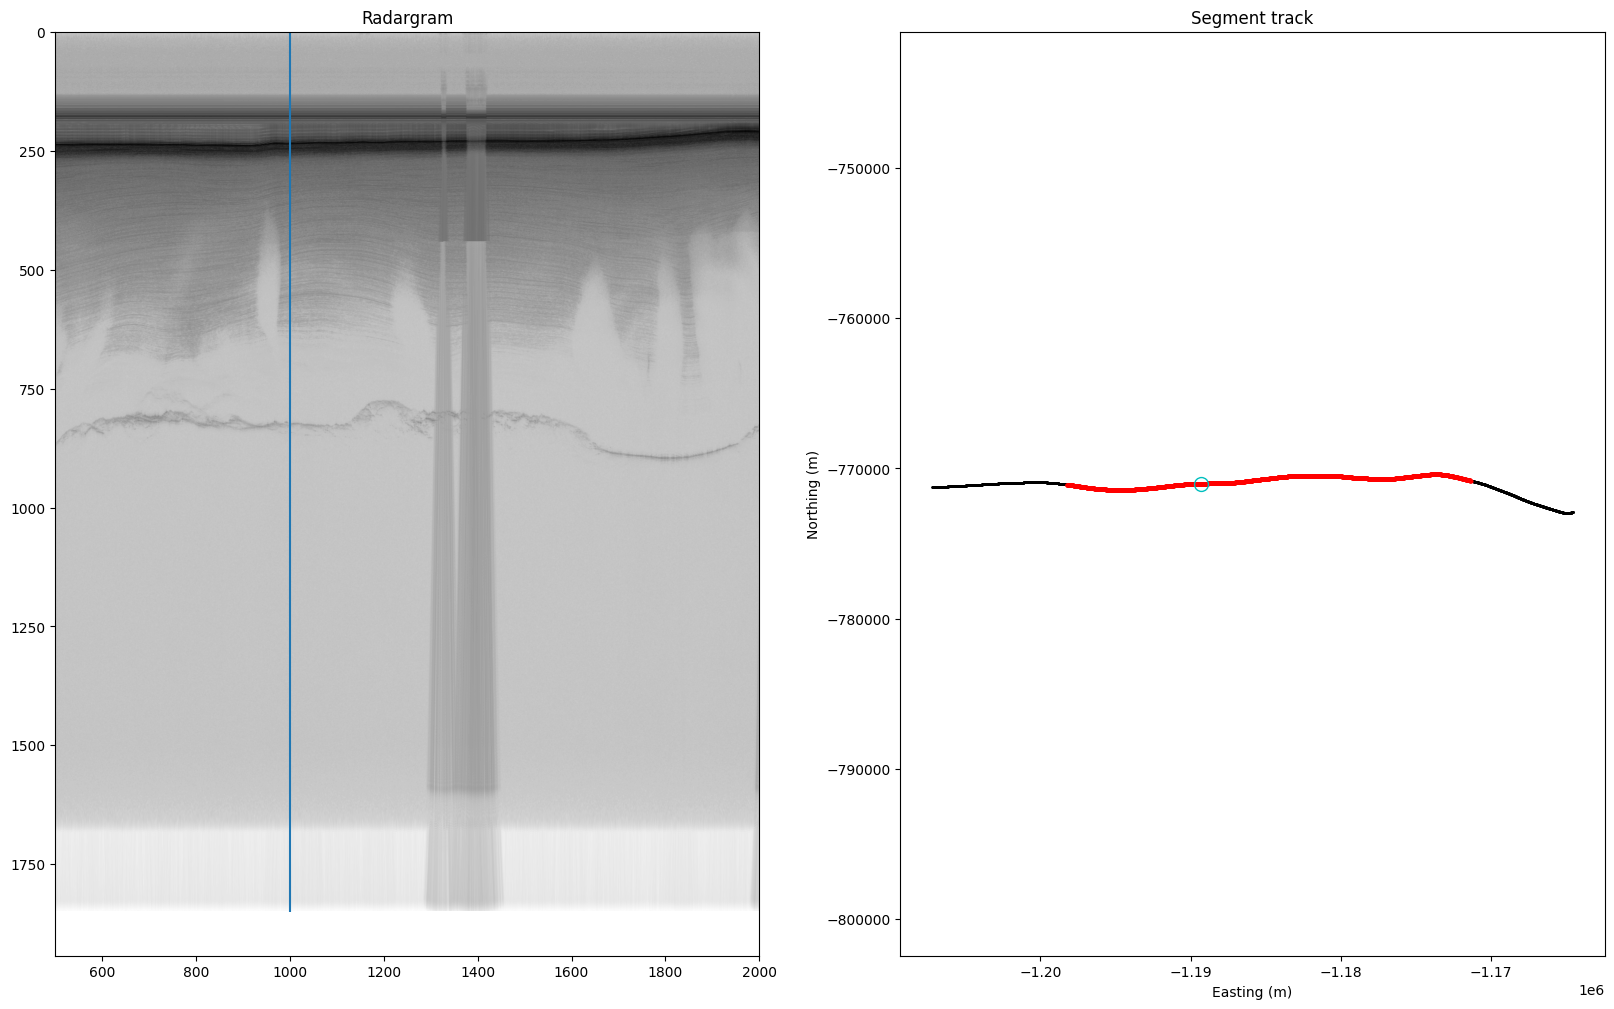

In [18]:
plot_cresis_matlab_radargram(new_datapath, (500, 2000), 1000)

In [27]:
new_datapath

'/Volumes/QIceRadar01/ANTARCTIC/CRESIS/2009_Antarctica_TO/CSARP_standard/20100118_01/Data_20100118_01_021.mat'

In [19]:
import pickle

In [21]:
# Now, let's check that the fields exist in each file:
cresis_datafiles = pickle.load(open("../../data/CRESIS/cresis_datafiles.pkl", 'rb'))

In [ ]:
#  cresis_datafiles[region][campaign][product][segment] = {file: "{}/{}".format(segment_url, file) for file in files}
for region, campaigns in cresis_datafiles.items():
    print(region)
    for campaign, products in campaigns.items():
        print(campaign)
        for product, segments in products.items():
            for segment, frames in segments.items():
                for frame in frames:
                    datapath = "/Users/lindzey/RadarData/{}/CRESIS/{}/{}/{}/{}".format(region, campaign, product, segment, frame)
                    if os.path.isfile(datapath):
                        print(datapath)
                        try:
                            with h5py.File(datapath, 'r') as data:
                                radargram = data['Data']    
                                lat = data['Latitude']
                                lon = data['Longitude']
                                if lat.shape[0] == radargram.shape[0]:
                                    print("Success for frame {}".format(frame))
                                else:
                                    print("ERROR: Radargram for {} has shape {}, but lat's shape is {}".format(datapath, radargram.shape, lat.shape))
                        except Exception as ex:
                            print("ERROR: ", ex)
                            
                        break # assume that if one file in a segment fails/works, they all will
                    else:
                        print("Could not find file! {}".format(datapath))
                break # assume we only need to test one flight in a campaign

In [29]:
ff = h5py.File('/Users/lindzey/RadarData/ARCTIC/CRESIS/2016_Greenland_G1XB/CSARP_standard/20160413_01/Data_20160413_01_001.mat', 'r')

In [30]:
ff.keys()

<KeysViewHDF5 ['#refs#', 'Bottom', 'Data', 'Elevation', 'GPS_time', 'Heading', 'Latitude', 'Longitude', 'Pitch', 'Roll', 'Surface', 'Time', 'param_combine', 'param_csarp', 'param_records']>

In [31]:
radargram = ff['Data']

In [32]:
radargram.shape

(404, 233)

In [33]:
ff['Longitude'].shape

(404, 1)

## Looking for DomeF core

In [34]:
domef_filepath = "/Users/lindzey/RadarData/ANTARCTIC/CRESIS/2018_Antarctica_Ground/CSARP_standard/20181231_01/Data_20181231_01_001.mat"

os.path.exists(domef_filepath)

True

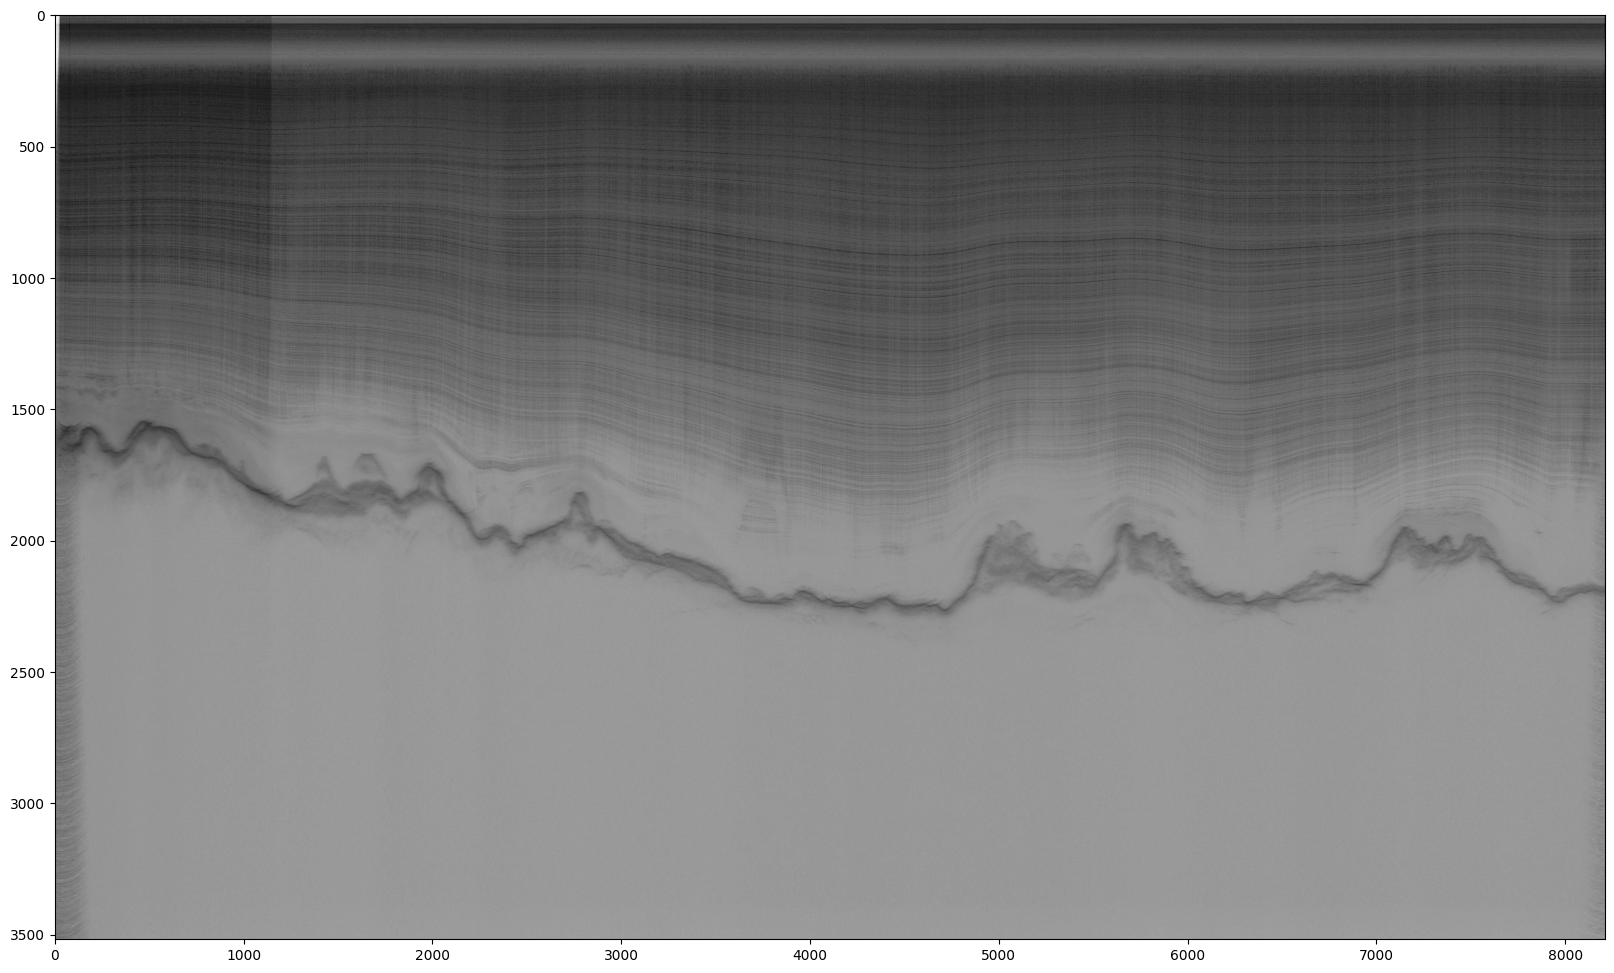

In [35]:
ff = h5py.File(domef_filepath, 'r')
radargram = ff['Data']    
radargram = np.log(np.array(radargram).transpose())
fig = plt.figure(figsize=(20, 12))
ax1 = fig.subplots(1)

ax1.imshow(radargram, cmap='Greys', aspect='auto')
fig.savefig("domef_cresis_20181231.png")



<class 'h5py._hl.dataset.Dataset'>
(3518, 8211) (8211, 1)
Radargram shape: (3518, 8211), lat shape: (8211, 1)


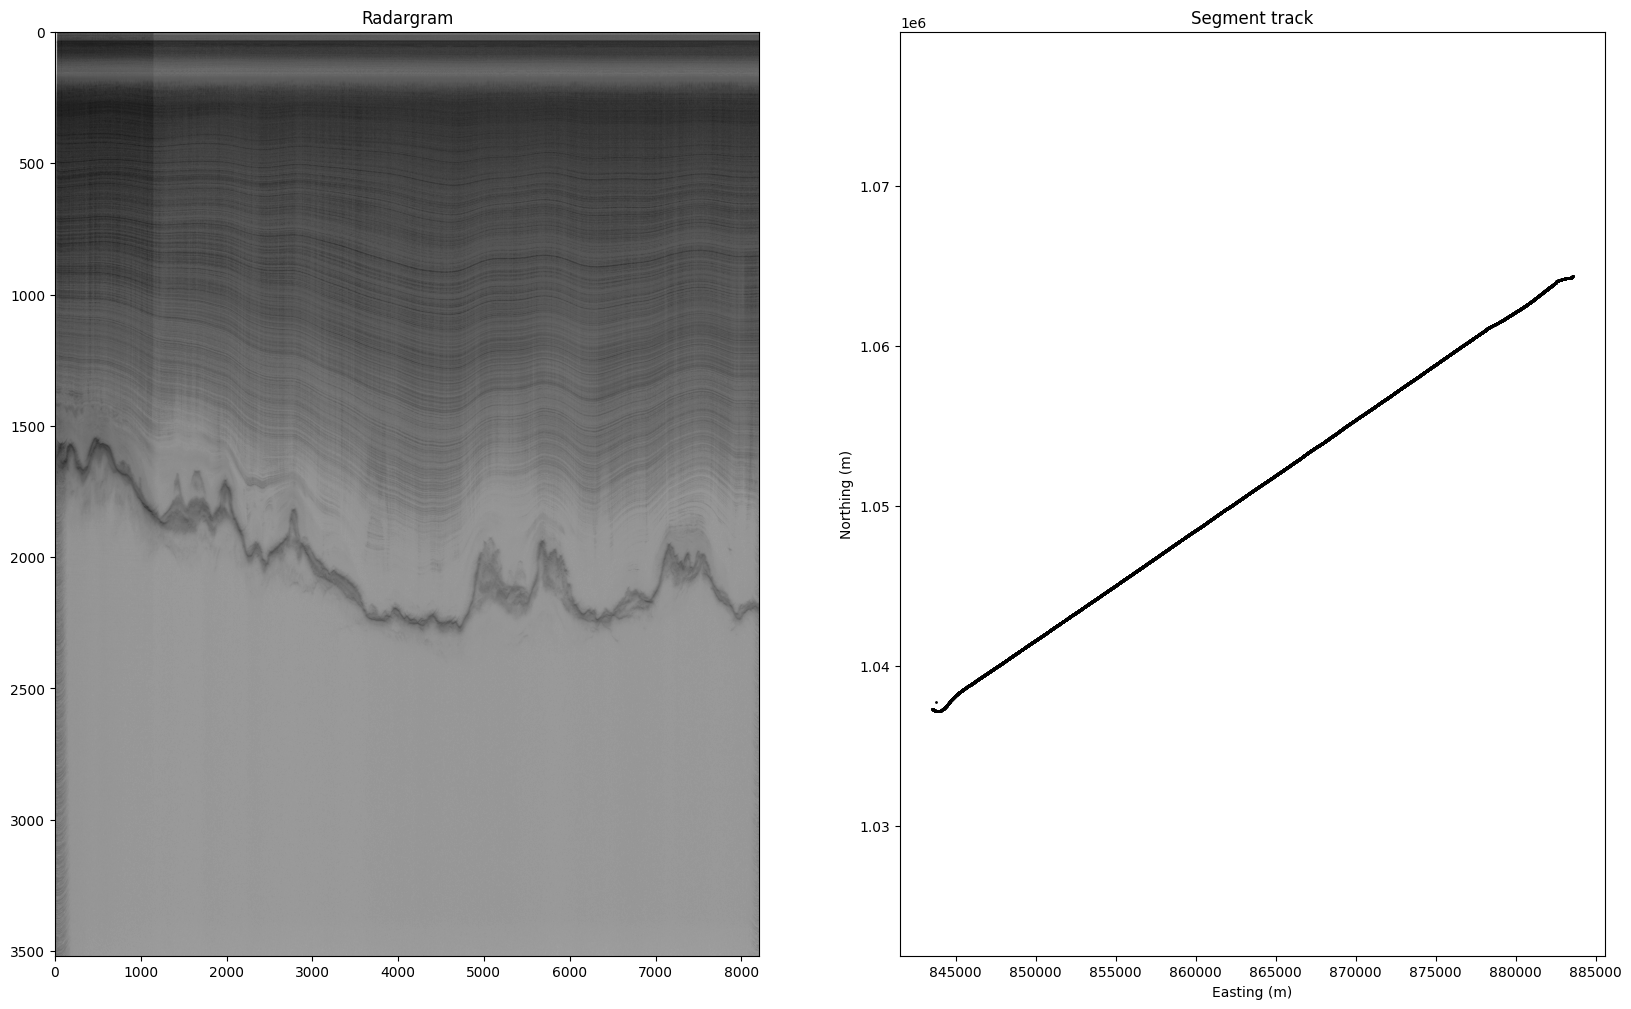

In [36]:
plot_cresis_matlab_radargram(domef_filepath)

